In [87]:
# Projet issu des données suivantes :

# https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

In [88]:
# Importation des library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [89]:
# Import et traitement des données
def imp_clean (chemin_fic,sepa) :
    df_train = pd.read_csv(chemin_fic, sep = sepa)
    # Obtenir les noms des variables
    noms_variables = df_train.columns
    # modification des noms des variables
    df_train = df_train.rename(columns={'battery_power': 'puissance_batterie', 
                         'blue': 'Bluetooth', 
                         'clock_speed': 'vitesse_micro_pross', 
                         'fc': 'nb_pixels_camera_front', 
                         'four_g': '4G', 
                         'int_memory': 'mémoire_interne',
                         'm_dep': 'profondeur_tel',
                         'mobile_wt': 'poids_tel',
                         'n_cores': 'nb_coeurs',
                         'pc': 'nb_pixels_camera_externe',
                         'px_height': 'pixels_resolution_hauteur',
                         'px_width': 'pixels_resolution_largeur',
                         'sc_h': 'hauteur_tel',
                         'sc_w': 'largeur_tel',
                         'talk_time': 'duree_batterie_appel',
                         'three_g': '3G',
                         'touch_screen': 'ecran_tactile'})
        # Remplacer les modalités dans la colonne
    nouveaux_noms_modalites = {0: 'bas de gamme', 1: 'prix moyen', 2: 'prix élevé', 3: 'haut de gamme'}
    df_train['price_range'] = df_train['price_range'].replace(nouveaux_noms_modalites)
    return df_train ,nouveaux_noms_modalites

In [90]:
#Fonction pour préparer le jeu de données avant la création du modèle
def preparation_pour_model(df_train) :
    # On sépare la variable à expliquer des variables explicatives
    X = df_train.drop("price_range",axis=1)
    y = df_train['price_range']
    # On split le train et le test à 80 % et 20 %
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0, stratify=y)
    # On prévoit d'utiliser le scaler pour centrer et réduire les variables quantitatives
    scaler = StandardScaler()
    # On applique le scaler à nos échantillons
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

In [91]:
#Fonction pour créer le modèle et sortir son score
def modelisation(X_train, X_test, y_train, y_test):
    # Application de la regression logistique sur notre échantillon d'apprentissage
    model = LogisticRegression()
    model.fit(X_train,y_train)
    model.score(X_train, y_train)

In [92]:
#Fonction pour sortir la matrice de confusion
def evaluation_model(X_train, X_test, y_train, y_test) :
    # Création de la pipeline
    pLg = make_pipeline(StandardScaler(),
                        LogisticRegression())
    pLg.fit(X_train, y_train)
    print(pLg.score(X_train, y_train), pLg.score(X_test, y_test))
    y_pred = pLg.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Convertir la matrice de confusion en pourcentage
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

    print("-------------------------------------------------------------------------")
    print(f"L'accuracy est de : ------>>  {accuracy_score(y_test, y_pred)}")
    print("-------------------------------------------------------------------------")
    print(f"La matrice de confusion (%) est la suivante : ------>> \n{conf_matrix_percent}")
    print("-------------------------------------------------------------------------")
    print(f"Tableau récapitulatif : ---->> {classification_report(y_test, y_pred)}")

In [93]:
#Fonction pour sortir la courbe ROC pour connaitre la capacité à bien prédire chaque classe  
def roc(scaler,nouveaux_noms_modalites):
    # Création de la courbe de ROC

    # Générer des données de démonstration
    X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1, random_state=0)

    # Binariser les étiquettes (dummies)
    y_bin = label_binarize(y, classes=[0, 1, 2, 3])

    # Diviser les données en ensemble d'entraînement et ensemble de test
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=0)

    # Utiliser OneVsRestClassifier avec un classificateur binaire (par exemple, Logistic Regression)
    classifier = OneVsRestClassifier(LogisticRegression())

    # On applique le scaler à nos échantillons
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Ajuster le modèle
    classifier.fit(X_train, y_train)

    # Obtenir les scores des probabilités
    y_score = classifier.predict_proba(X_test)

    # Calculer les courbes ROC et les aires sous la courbe pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):  # 4 classes dans cet exemple
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Tracer les courbes ROC
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'{nouveaux_noms_modalites[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positif')
    plt.ylabel('Taux de vrai positif')
    plt.title('Courbes ROC des différentes classes de prix')
    plt.legend(loc='lower right')
    plt.show()

In [94]:
def main(chemin,separ) :
    df_train, nouveaux_noms_modalites= imp_clean(chemin,separ)
    X_train, X_test, y_train, y_test, scaler = preparation_pour_model(df_train)
    modelisation(X_train, X_test, y_train, y_test)
    evaluation_model(X_train, X_test, y_train, y_test)
    roc(scaler,nouveaux_noms_modalites)

0.9775 0.9725
-------------------------------------------------------------------------
L'accuracy est de : ------>>  0.9725
-------------------------------------------------------------------------
La matrice de confusion (%) est la suivante : ------>> 
[[97.  0.  3.  0.]
 [ 0. 99.  0.  1.]
 [ 2.  0. 95.  3.]
 [ 0.  0.  2. 98.]]
-------------------------------------------------------------------------
Tableau récapitulatif : ---->>                precision    recall  f1-score   support

 bas de gamme       0.98      0.97      0.97       100
haut de gamme       1.00      0.99      0.99       100
   prix moyen       0.95      0.95      0.95       100
   prix élevé       0.96      0.98      0.97       100

     accuracy                           0.97       400
    macro avg       0.97      0.97      0.97       400
 weighted avg       0.97      0.97      0.97       400



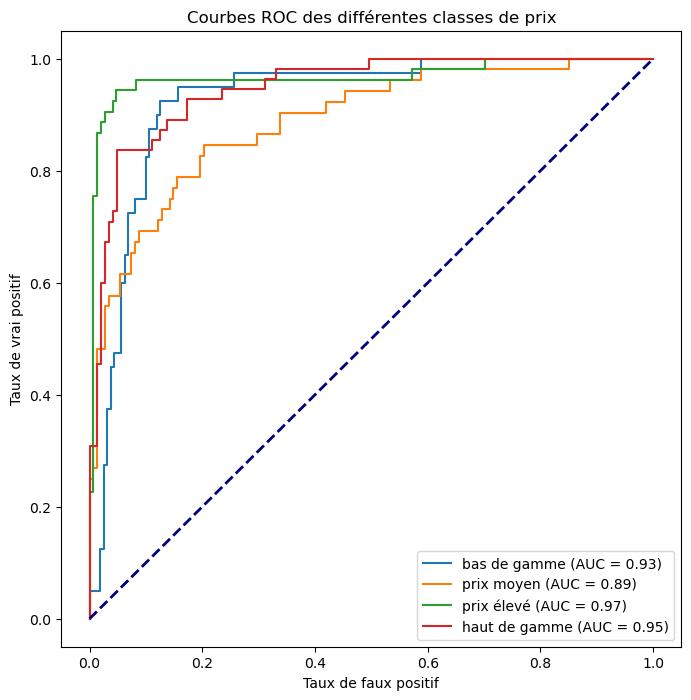

In [95]:
main('train.csv',',')